In [1]:
from data_loader import load_data, load_data_sample
from models import LogisticLogOddsModel, XGBoostLogOddsModel
from explainers import SHAPExplainer
from util import printmd
import shap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import sklearn
import numpy as np

In [2]:
notebook_name = 'Compare Explanations of Log Odds with SHAP'
printmd(f'# {notebook_name}')
%matplotlib inline

# Compare Explanations of Log Odds with SHAP

In [3]:
X, y, display_data = load_data()
feature_names = list(X.columns)
model_a = LogisticLogOddsModel()
model_a.load_or_train(X, y)
model_b = XGBoostLogOddsModel()
model_b.load_or_train(X, y)

Loaded model: models/Logistic.model
Loaded model: models/XGBoost.model


In [4]:
X_sample, y_sample, display_data_sample = load_data_sample()
explanation_a = SHAPExplainer(model_a, notebook_name + '.a')
explanation_a.load_or_generate(X_sample, display_data_sample)
explanation_b = SHAPExplainer(model_b, notebook_name + '.b')
explanation_b.load_or_generate(X_sample, display_data_sample)

divide by zero encountered in log
divide by zero encountered in log
Permutation explainer: 1001it [00:29, 23.87it/s]                         


Finished generating: models/Compare Explanations of Log Odds with SHAP.a.exp (0:00:29.508162)


Permutation explainer: 1001it [00:31, 21.17it/s]                         

Finished generating: models/Compare Explanations of Log Odds with SHAP.b.exp (0:00:32.009139)


In [5]:
# attention: some SHAP values are infinity or negative infinity
df_a = pd.DataFrame(explanation_a.shap_values.values)
exclude_a = df_a.index[np.isinf(df_a).any(1)].to_list()
df_b = pd.DataFrame(explanation_b.shap_values.values)
exclude_b = df_b.index[np.isinf(df_b).any(1)].to_list()
exclude = list(set(exclude_a + exclude_b))
printmd(f'Excluding instances:')
pd.DataFrame(explanation_a.shap_values[exclude].display_data, columns=feature_names, index=exclude)

Excluding instances:

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
139,41,Self-emp-inc,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States


In [6]:
printmd('Corresponding Shapley values:')
pd.DataFrame(explanation_a.shap_values[exclude].values, columns=feature_names, index=exclude)

Corresponding Shapley values:

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
139,0.079277,-0.024872,inf,0.099542,0.066911,0.652173,0.035021,0.174737,32.618801,-inf,1.04337,0.027544


In [7]:
explanation_a.shap_values = explanation_a.shap_values[[v for v in range(len(explanation_a.shap_values)) if not v in exclude]]
explanation_b.shap_values = explanation_b.shap_values[[v for v in range(len(explanation_b.shap_values)) if not v in exclude]]

## Scatter plots
They are generalizations of the partial dependence plots.

With the parameter color, we instruct SHAP to pick the feature that has the biggest interaction effects with the explained feature and to colour the observations according to its' shapeley values.

### Age

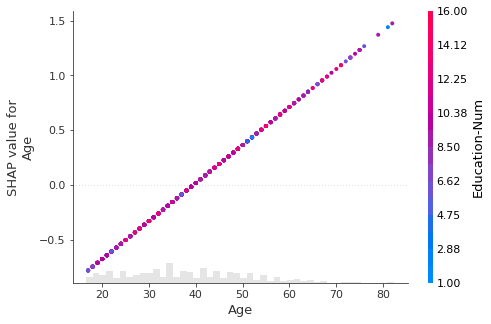

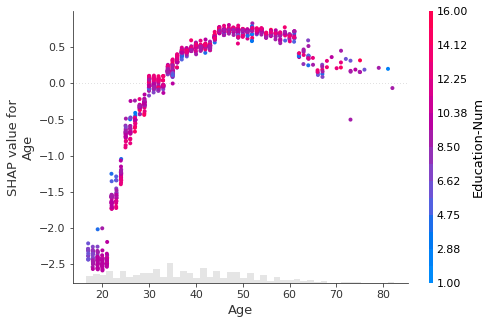

### Workclass

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


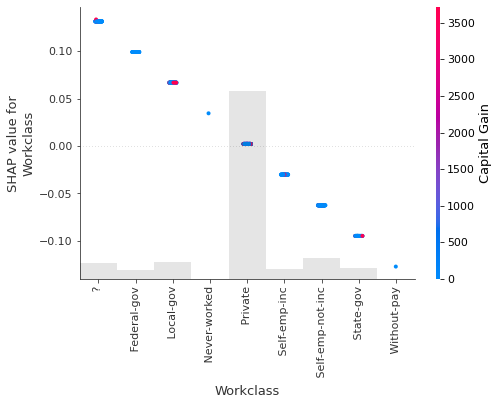

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


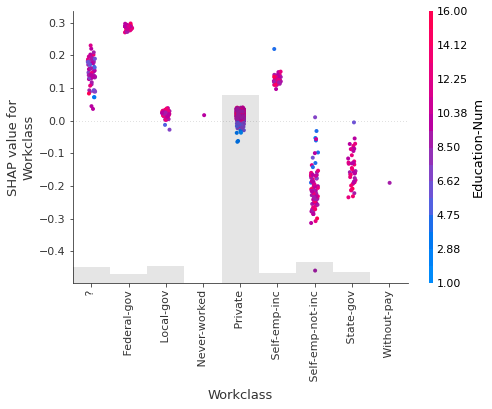

### Education-Num

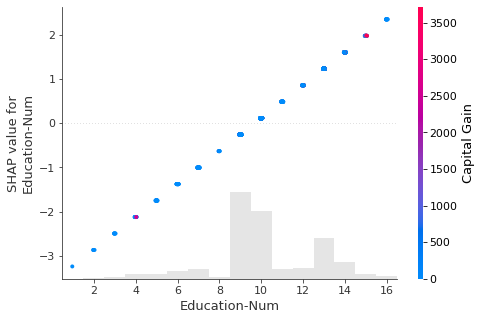

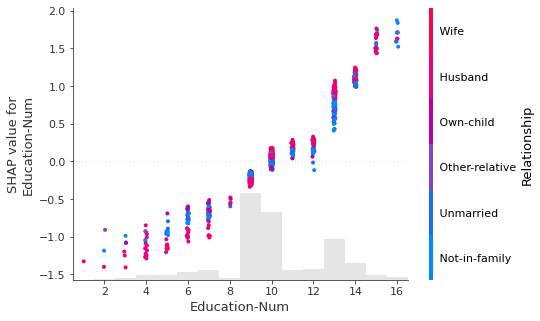

### Marital Status

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


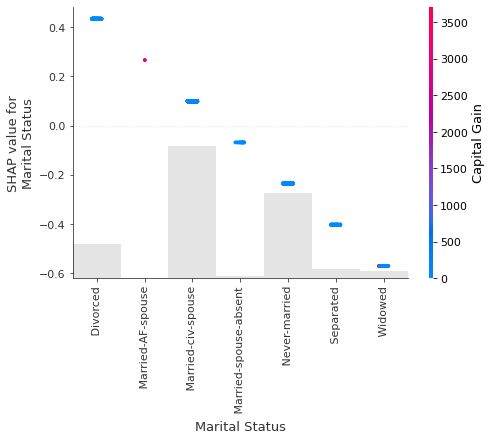

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


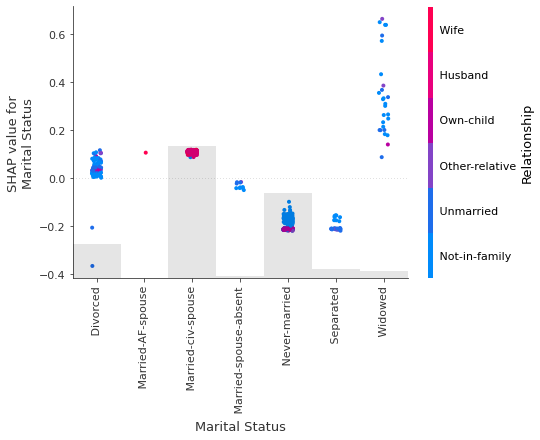

### Occupation

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


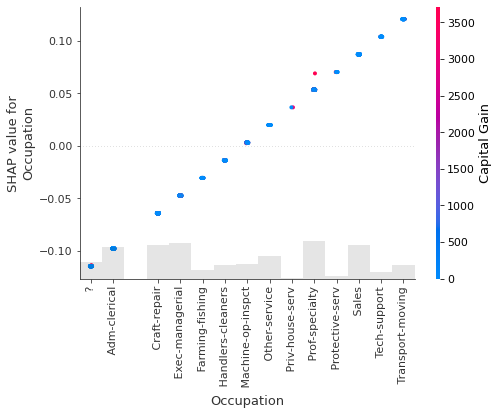

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


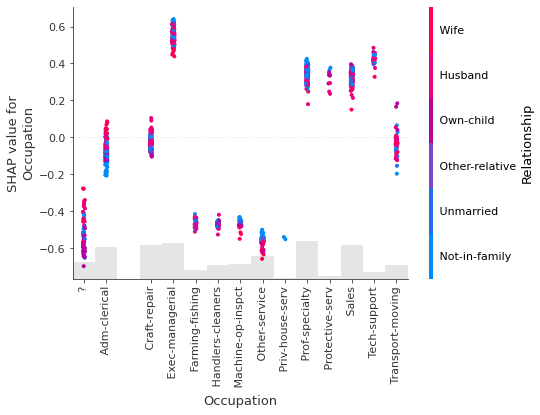

### Relationship

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


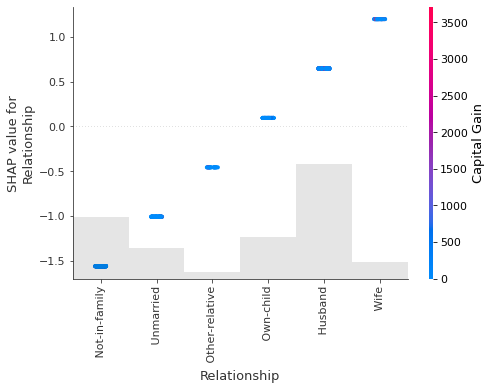

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


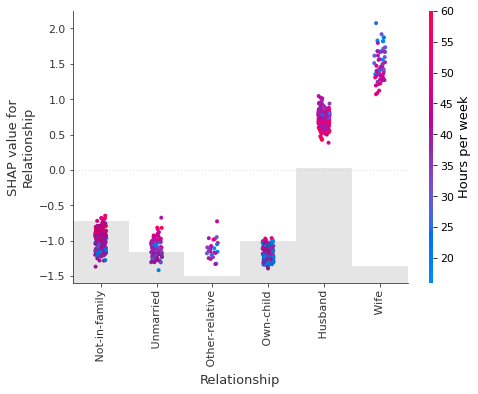

### Race

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


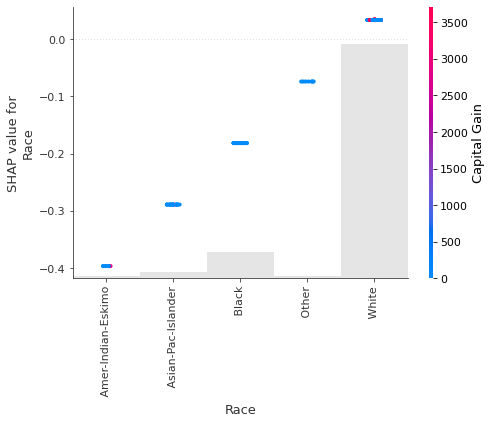

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


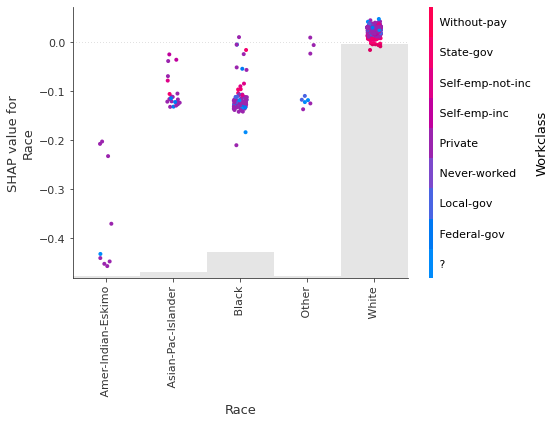

### Sex

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


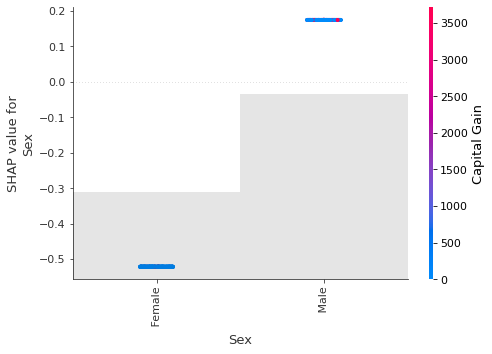

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


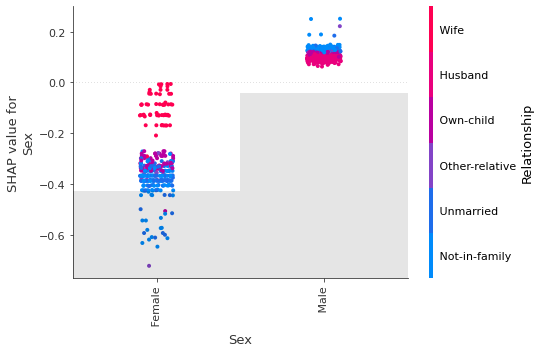

### Capital Gain

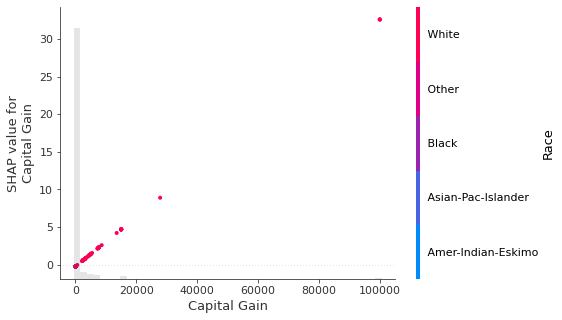

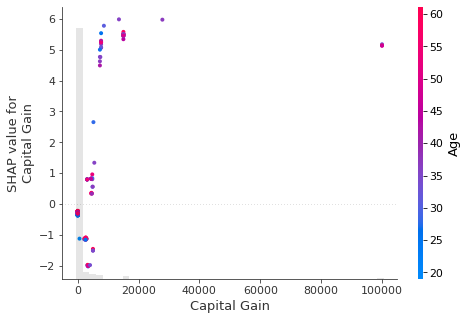

### Capital Loss

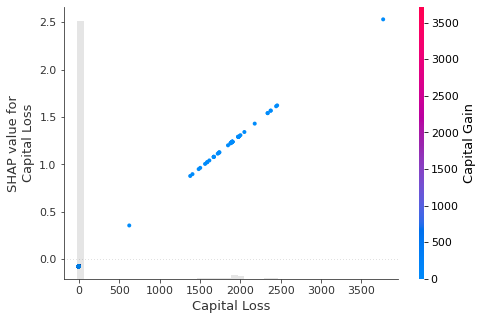

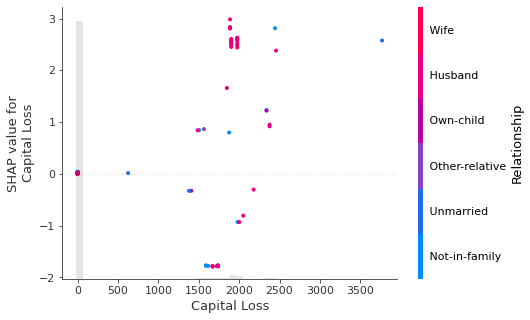

### Hours per week

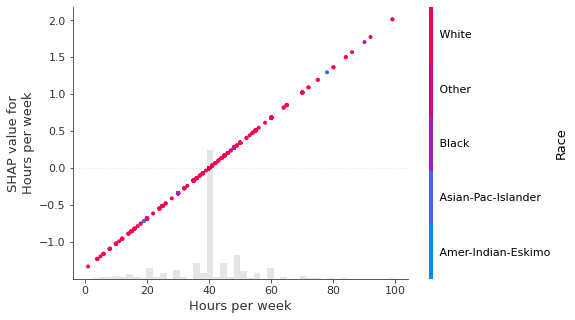

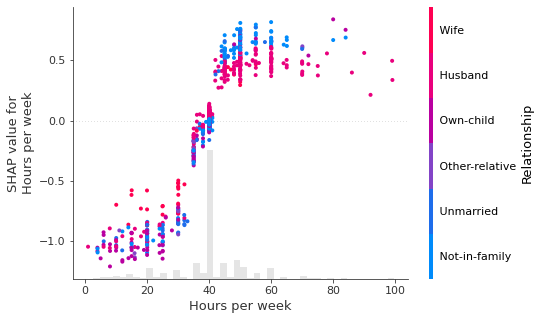

### Country

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


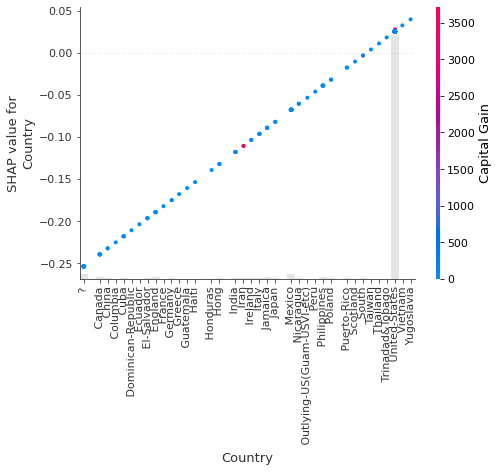

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


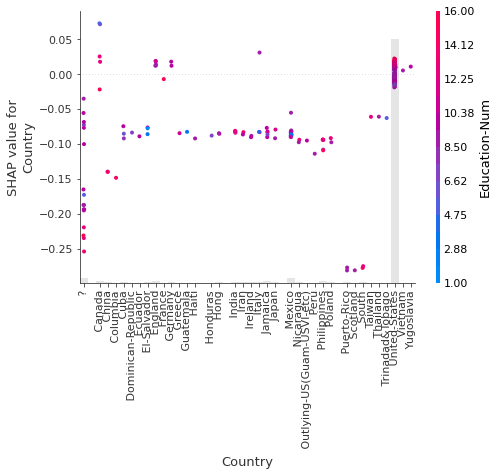

In [8]:
for feature_name in X.columns:
    printmd(f'### {feature_name}')
    for explanation in (explanation_a, explanation_b):
        shap.plots.scatter(explanation.shap_values[:,feature_name], color=explanation.shap_values)

Notice the strong interaction effect in the plots of model A. Logistic regression is better explained using the log of odds instead of probabilities.

## Bar plots
> By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

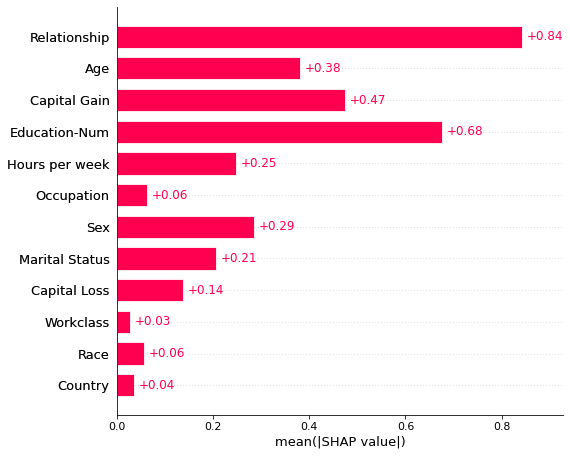

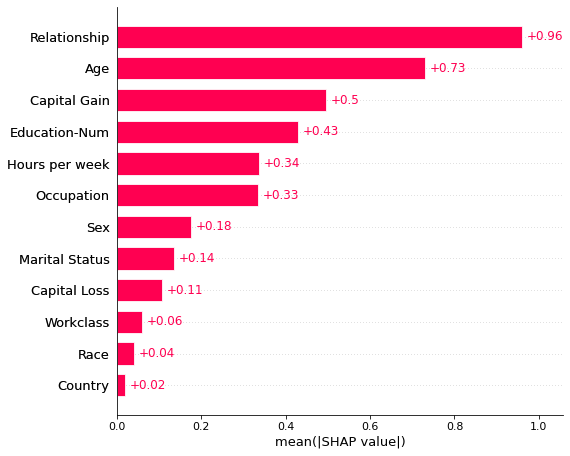

In [9]:
order = np.argsort(-explanation_b.shap_values.abs.mean(0).values)
for explanation in (explanation_a, explanation_b):
    shap.plots.bar(explanation.shap_values, max_display=len(feature_names), order=order)

> But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrewuent but high magnitude effects.

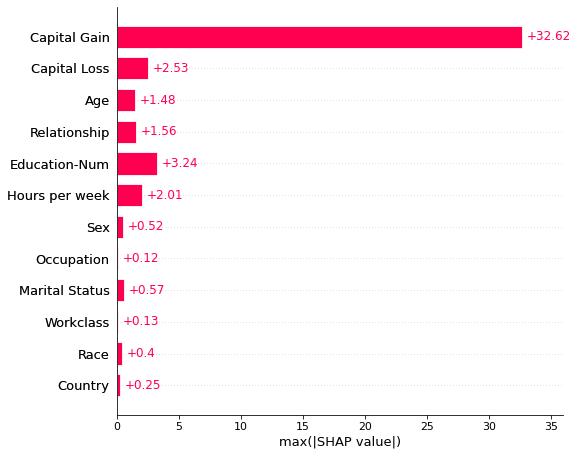

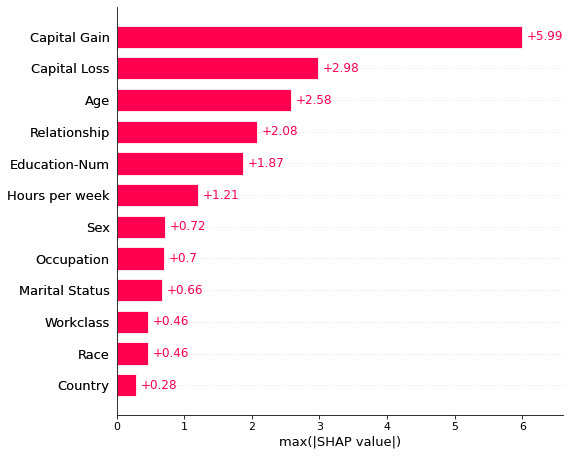

In [10]:
order = np.argsort(-explanation_b.shap_values.abs.max(0).values)
for explanation in (explanation_a, explanation_b):
    shap.plots.bar(explanation.shap_values.abs.max(0), max_display=len(feature_names), order=order)

We can also compare feature importance for subsets separately, like for men and women:

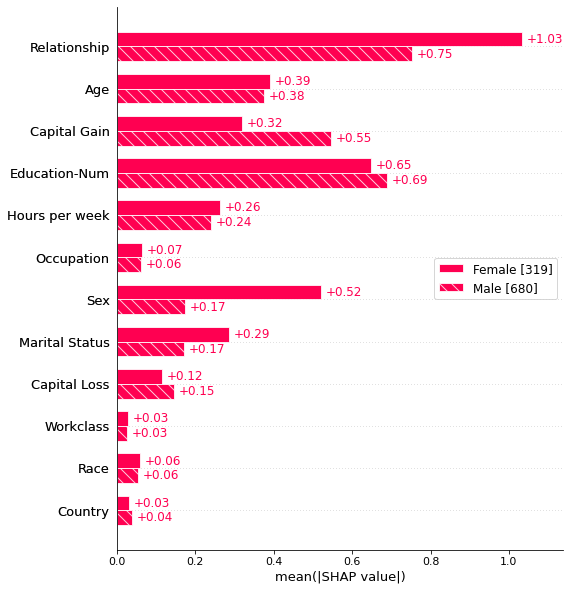

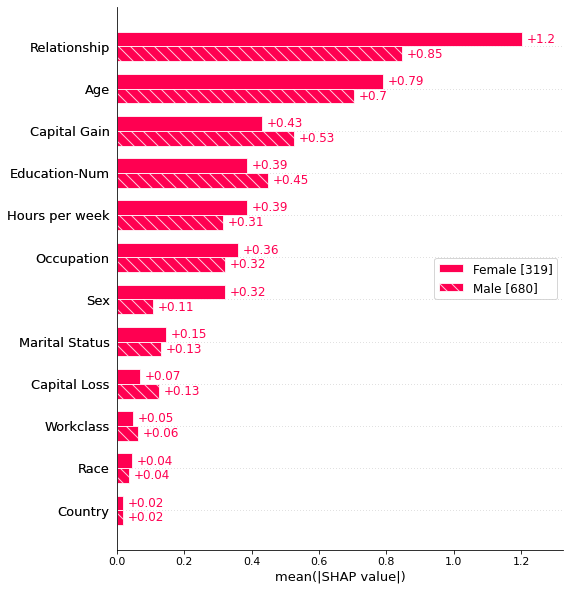

In [11]:
order = np.argsort(-explanation_b.shap_values.abs.mean(0).values)
sex = pd.DataFrame(explanation_b.shap_values.display_data, columns=feature_names)['Sex'].str.strip().to_list()
for explanation in (explanation_a, explanation_b):
    shap.plots.bar(explanation.shap_values.cohorts(sex).abs.mean(0), max_display=len(feature_names), order=order)

## Beeswarm plots
They show the Shapeley value distribution per feature.
> If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

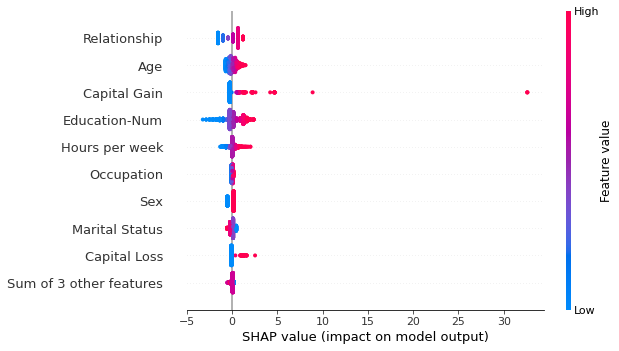

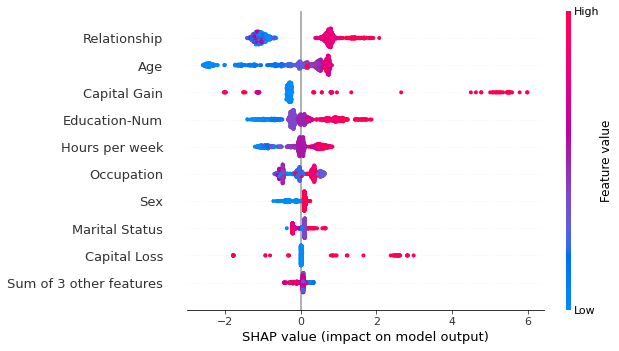

In [12]:
order = np.argsort(-explanation_b.shap_values.abs.mean(0).values)
for explanation in (explanation_a, explanation_b):
    shap.plots.beeswarm(explanation.shap_values, order=order)

> By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

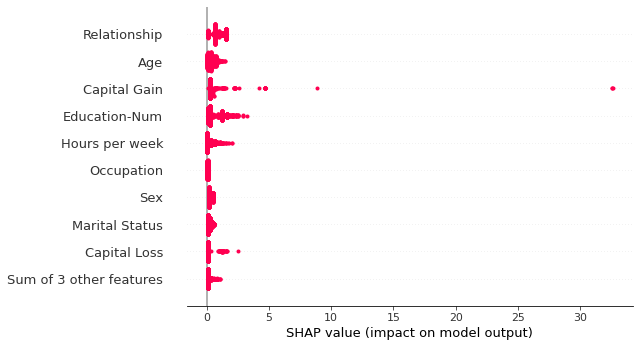

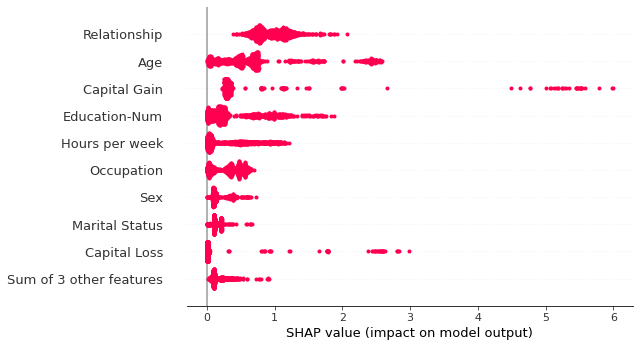

In [13]:
for explanation in (explanation_a, explanation_b):
    shap.plots.beeswarm(explanation.shap_values.abs, color="shap_red", order=order)

Or we  could simplify the visualization of the distribution by using violin plots:

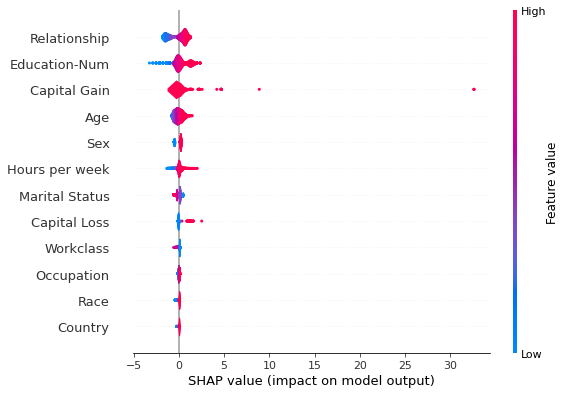

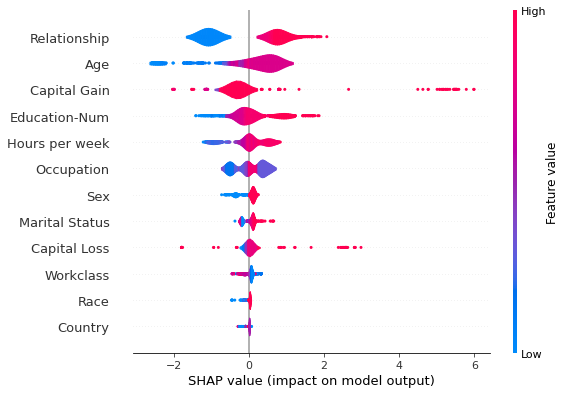

In [14]:
# unfortunately, violin plot has no option to set the order
for explanation in (explanation_a, explanation_b):
    shap.plots.violin(explanation.shap_values.values, features=explanation.shap_values.data, feature_names=feature_names)

## Forceplot

In [15]:
shap.initjs()

In [16]:
plot_b = shap.plots.force(
    base_value=explanation_b.shap_values.abs.mean(0).base_values,
    shap_values=explanation_b.shap_values.values,
    features=explanation_b.shap_values.display_data,
    feature_names=feature_names,
    out_names='model B')
ordering=list(map(lambda x: int(x['simIndex']), plot_b.data['explanations']))

In [17]:
shap.plots.force(
    base_value=explanation_a.shap_values.abs.mean(0).base_values,
    shap_values=explanation_a.shap_values.values,
    features=explanation_a.shap_values.display_data,
    feature_names=feature_names,
    out_names='model A',
    ordering_keys=ordering)

In [18]:
plot_b

## Plot embeddings
Use the SHAP values as an embedding which we project to 2D for visualization, using PCA.

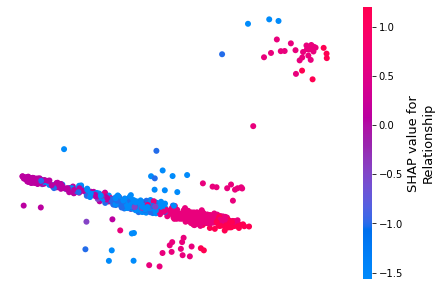

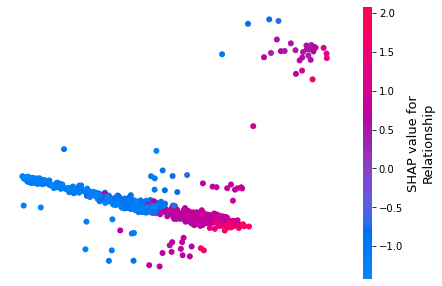

In [19]:
pca = sklearn.decomposition.PCA(2)
embedding_values = pca.fit_transform(explanation_b.shap_values.values)
for explanation in (explanation_a, explanation_b):
    shap.plots.embedding('Relationship', explanation.shap_values.values, feature_names=feature_names, method=embedding_values)

## Heatmap
Here we use a supervised hierarchical clustering method to visualize the SHAP values

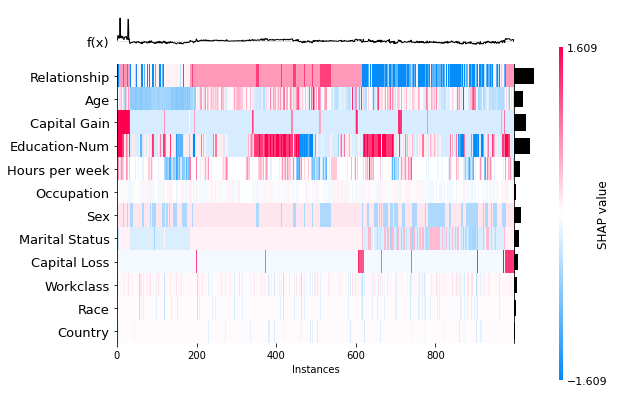

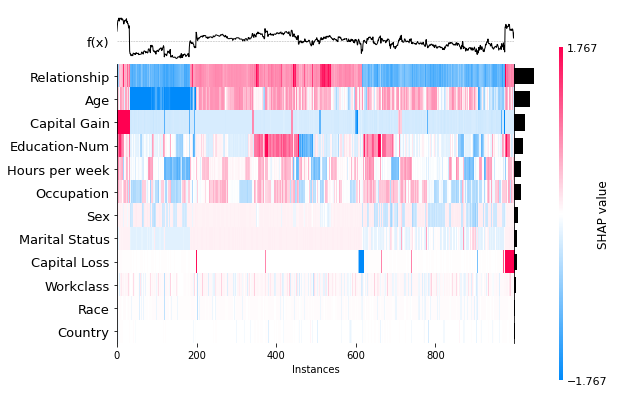

In [20]:
instance_order = explanation_b.shap_values.hclust()
feature_order = np.argsort(-explanation_b.shap_values.abs.mean(0).values)
for explanation in (explanation_a, explanation_b):
    shap.plots.heatmap(explanation.shap_values, instance_order=instance_order, feature_order=feature_order, max_display=len(feature_names))